# Задания

1. Продемонстрировать сохранение свойств исходного датасета при разбиении на тренировочную и тестовую (например, сохранения типа распределения) части для пользовательских и/или модельных данных.

2. Реализовать процедуру перекрестной проверки для пользовательских и/или модельных данных. Продемонстрировать процесс наглядно.

3. Для пользовательских и/или модельных данных реализовать сравнение скорости и точности результатов методов после применения перебора гиперпараметров по сетке, методом случайного поиска и с использованием байесовской оптимизации.

## Разделение на тренировочную и тестовую выборку

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [2]:
df = pd.read_csv('xAPI-Edu-Data.csv')
df.head(2)

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M


In [3]:
def plot_category(feature, df, figsize=None):
    low = df[df['Class']=='L'].groupby([feature]).size()
    medium = df[df['Class']=='M'].groupby([feature]).size()
    high = df[df['Class']=='H'].groupby([feature]).size()
    labels = low.index

    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    if figsize:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig, ax = plt.subplots()
    
    rects1 = ax.bar(x - width, round(low * 100 / df.groupby([feature]).size(), 2), width, label='L')
    rects2 = ax.bar(x, round(medium * 100 / df.groupby([feature]).size(), 2), width, label='M')
    rects3 = ax.bar(x + width, round(high * 100 / df.groupby([feature]).size(), 2), width, label='H')

    ax.set_ylabel('Percentage')
    ax.set_title('Distribution of Classes based on %s' % feature)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=80)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    ax.bar_label(rects3, padding=3)
    

    fig.tight_layout()
    plt.show()

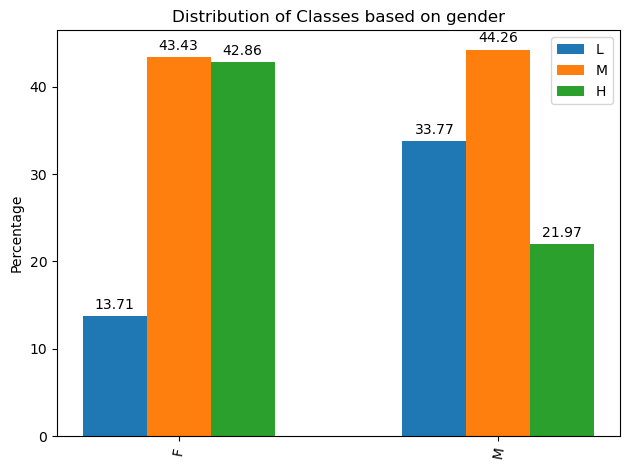

In [4]:
for feature in ['gender']:
    plot_category(feature, df)

In [5]:
#Предобработка
from sklearn.preprocessing import LabelEncoder
Features = df.drop('Class',axis=1)
Target = df['Class']
label = LabelEncoder()
Cat_Colums = Features.dtypes.pipe(lambda Features: Features[Features=='object']).index
for col in Cat_Colums:
    Features[col] = label.fit_transform(Features[col])

In [6]:
#Разделение
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Features, Target, test_size=0.15, random_state=52)

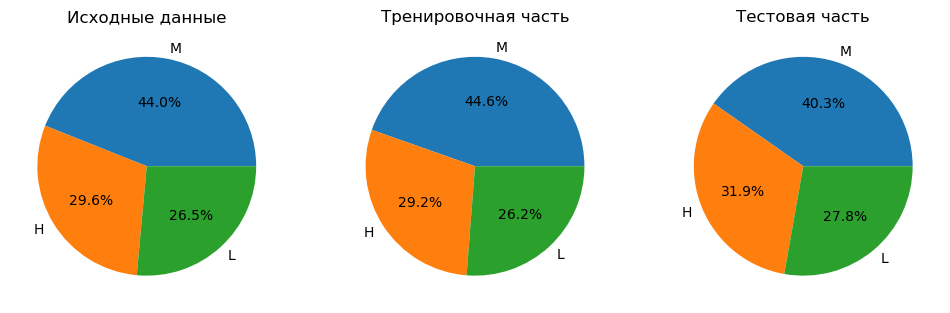

In [8]:
import matplotlib.pyplot as plt

# Создание фигуры с тремя подграфиками
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# Количество нулей и единиц в переменной y
y_counts = Target.value_counts()
axes[0].pie(y_counts, labels=y_counts.index, autopct='%1.1f%%')
axes[0].set_title('Исходные данные')

# Количество нулей и единиц в переменной y_train
y_train_counts = y_train.value_counts()
axes[1].pie(y_train_counts, labels=y_train_counts.index, autopct='%1.1f%%')
axes[1].set_title('Тренировочная часть')

# Количество нулей и единиц в переменной y_test
y_test_counts = y_test.value_counts()
axes[2].pie(y_test_counts, labels=y_test_counts.index, autopct='%1.1f%%')
axes[2].set_title('Тестовая часть')

# Отображение диаграмм
plt.show()

## Реализовать кросс-валидацию

In [14]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score

clf = DecisionTreeClassifier(random_state=42) # Создает объект DecisionTreeClassifier с фиксированным состоянием генератора случайных чисел

k_folds = KFold(n_splits = 5)

scores = cross_val_score(clf, X_train, y_train, cv = k_folds)

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())


Cross Validation Scores:  [0.7804878  0.68292683 0.59756098 0.71604938 0.64197531]
Average CV Score:  0.6838000602228245


<BarContainer object of 5 artists>

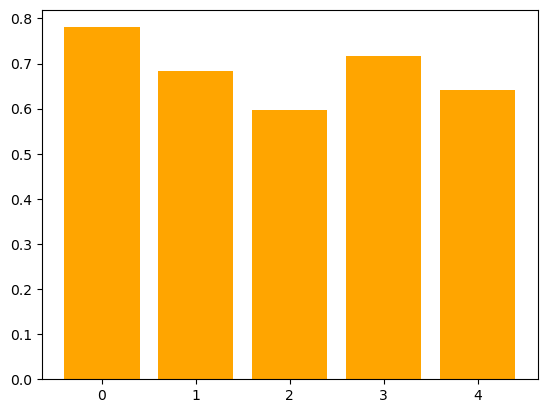

In [16]:
plt.bar(range(len(scores)), scores, color = 'orange')

## Методы перебора гиперпараметров

In [19]:
import warnings
warnings.filterwarnings("ignore")

In [64]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
import time


# Загрузка датасета Iris
iris = load_iris()
X = Features_enc
y = Target

# Определение модели
model = RandomForestClassifier()

grid_params = {'n_estimators': [1, 2, 3, 5, 10, 25, 50, 75, 100], 'max_depth': [2, 3, 5, 10]}
random_params = {'n_estimators': [1, 2, 3, 5, 10, 25, 50, 75, 100], 'max_depth': [2, 3, 5, 10]}
bayes_params = {'n_estimators': (1, 100), 'max_depth': (2, 10)}

# Перебор гиперпараметров по сетке
start_time = time.time()
grid_search = GridSearchCV(model, grid_params)
grid_search.fit(X_train, y_train)
grid_pred = grid_search.predict(X_test)
end_time = time.time()
grid_search_time = end_time - start_time
print("Метод перебора по сетке:")
print("Точность:", accuracy_score(y_test, grid_pred))
print("Время работы:", grid_search_time, "сек")
print("--------------------------------------------")

# Случайный поиск гиперпараметров
start_time = time.time()
random_search = RandomizedSearchCV(model, random_params)
random_search.fit(X_train, y_train)
random_pred = random_search.predict(X_test)
end_time = time.time()
random_search_time = end_time - start_time
print("Метод случайного поиска:")
print("Точность:", accuracy_score(y_test, random_pred))
print("Время работы:", random_search_time, "сек")
print("--------------------------------------------")

# Байесовский
import optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 10)
    }
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    mod_pr = model.predict(X_test)
    accur = accuracy_score(y_test, mod_pr)
    return accur
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
end_time = time.time()
bayes_search_time = end_time - start_time
best_params = study.best_params
best_score = study.best_value
print("Метод байесовской оптимизации:")
print("Точность:", best_score)
print("Время работы:", bayes_search_time, "сек")

Метод перебора по сетке:
Точность: 0.8611111111111112
Время работы: 15.95027208328247 сек
--------------------------------------------


[I 2023-12-07 14:26:28,832] A new study created in memory with name: no-name-7b462436-7fdb-4ddb-ba23-3fcc6b64a50d
[I 2023-12-07 14:26:28,908] Trial 0 finished with value: 0.8472222222222222 and parameters: {'n_estimators': 19, 'max_depth': 10}. Best is trial 0 with value: 0.8472222222222222.


Метод случайного поиска:
Точность: 0.8055555555555556
Время работы: 6.2760090827941895 сек
--------------------------------------------


[I 2023-12-07 14:26:29,059] Trial 1 finished with value: 0.8888888888888888 and parameters: {'n_estimators': 46, 'max_depth': 8}. Best is trial 1 with value: 0.8888888888888888.
[I 2023-12-07 14:26:29,078] Trial 2 finished with value: 0.8055555555555556 and parameters: {'n_estimators': 3, 'max_depth': 9}. Best is trial 1 with value: 0.8888888888888888.
[I 2023-12-07 14:26:29,142] Trial 3 finished with value: 0.7916666666666666 and parameters: {'n_estimators': 17, 'max_depth': 10}. Best is trial 1 with value: 0.8888888888888888.
[I 2023-12-07 14:26:29,211] Trial 4 finished with value: 0.7916666666666666 and parameters: {'n_estimators': 24, 'max_depth': 3}. Best is trial 1 with value: 0.8888888888888888.
[I 2023-12-07 14:26:29,408] Trial 5 finished with value: 0.8333333333333334 and parameters: {'n_estimators': 59, 'max_depth': 8}. Best is trial 1 with value: 0.8888888888888888.
[I 2023-12-07 14:26:29,505] Trial 6 finished with value: 0.7916666666666666 and parameters: {'n_estimators': 3

Метод байесовской оптимизации:
Точность: 0.8888888888888888
Время работы: 14.622408390045166 сек
